# Exploratory Data Analysis and Preprocessing


In [1]:
import kagglehub
kagglehub.login()

Kaggle credentials set.
Kaggle credentials successfully validated.


In [2]:
isic_2024_challenge_path = kagglehub.competition_download('isic-2024-challenge')

100%|██████████| 2.00G/2.00G [01:32<00:00, 23.3MB/s]

Extracting files...


In [18]:
##############
# LIBRARIES
##############

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import cv2
import os
import matplotlib.image as mpimg

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import warnings
warnings.filterwarnings("ignore")


# Row Column Settings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.width', 500)

In [8]:
##############
# LOAD DATA
##############

train_metadata_path = f"{isic_2024_challenge_path}/train-metadata.csv"
train_image_dir = f"{isic_2024_challenge_path}/train-image"

# Read Data
train_metadata = pd.read_csv(train_metadata_path, low_memory=False)

In [9]:
#######
# DROP
#######

# Variables with a high number of missing values or that do not carry significant information have been removed.

drop_list = [
    'patient_id',
    'attribution',
    'copyright_license',
    'image_type',
    'iddx_1',
    'iddx_2',
    'iddx_3',
    'iddx_4',
    'iddx_5',
    'iddx_full',
    'lesion_id',
    'mel_mitotic_index',
    'mel_thick_mm',
    'tbp_lv_dnn_lesion_confidence'
]

train_metadata.drop(drop_list, axis=1, inplace=True)

## Data Analysis

In [10]:
percentiles = [0.10, 0.25, 0.30, 0.40, 0.60, 0.70, 0.80, 0.85, 0.90, 0.95, 0.99]
train_metadata.describe(percentiles = percentiles).T.style.background_gradient(axis=0, cmap='coolwarm')

,count,mean,std,min,10%,25%,30%,40%,50%,60%,70%,80%,85%,90%,95%,99%,max
target,401059.000000,0.000980,0.031288,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
age_approx,398261.000000,58.012986,13.596165,5.000000,40.000000,50.000000,50.000000,55.000000,60.000000,60.000000,65.000000,70.000000,75.000000,75.000000,80.000000,85.000000,85.000000
clin_size_long_diam_mm,401059.000000,3.930827,1.743068,1.000000,2.600000,2.840000,2.910000,3.120000,3.370000,3.680000,4.100000,4.730000,5.210000,5.930000,7.300000,10.950000,28.400000
tbp_lv_A,401059.000000,19.974007,3.999489,-2.487115,15.123632,17.330821,17.873300,18.872050,19.801910,20.737157,21.741557,22.954056,23.749276,24.811110,26.620928,31.630467,48.189610
tbp_lv_Aext,401059.000000,14.919247,3.529384,-9.080269,10.568060,12.469740,12.959588,13.851970,14.713930,15.612554,16.584306,17.745172,18.472236,19.438542,21.005880,24.352946,37.021680
tbp_lv_B,401059.000000,28.281706,5.278676,-0.730989,21.668048,24.704372,25.475673,26.863360,28.171570,29.486569,30.871697,32.510270,33.572453,34.981533,37.310771,41.647612,54.306900
tbp_lv_Bext,401059.000000,26.913015,4.482994,9.237066,21.377648,23.848125,24.474702,25.620707,26.701704,27.789578,28.995086,30.467990,31.427985,32.697662,34.778238,38.743201,48.372700
tbp_lv_C,401059.000000,34.786341,5.708469,3.054228,27.500756,31.003148,31.858650,33.401279,34.822580,36.206228,37.643586,39.331535,40.414032,41.897834,44.314433,49.009580,58.765170
tbp_lv_Cext,401059.000000,30.921279,4.829345,11.846520,24.851942,27.658285,28.354740,29.627650,30.804893,31.988790,33.249996,34.783186,35.769782,37.064196,39.138784,43.420112,54.305290
tbp_lv_H,401059.000000,54.653689,5.520849,-1.574164,47.896213,51.566273,52.366540,53.766961,55.035632,56.277159,57.577932,59.088676,60.022736,61.193510,62.888295,65.986340,105.875784


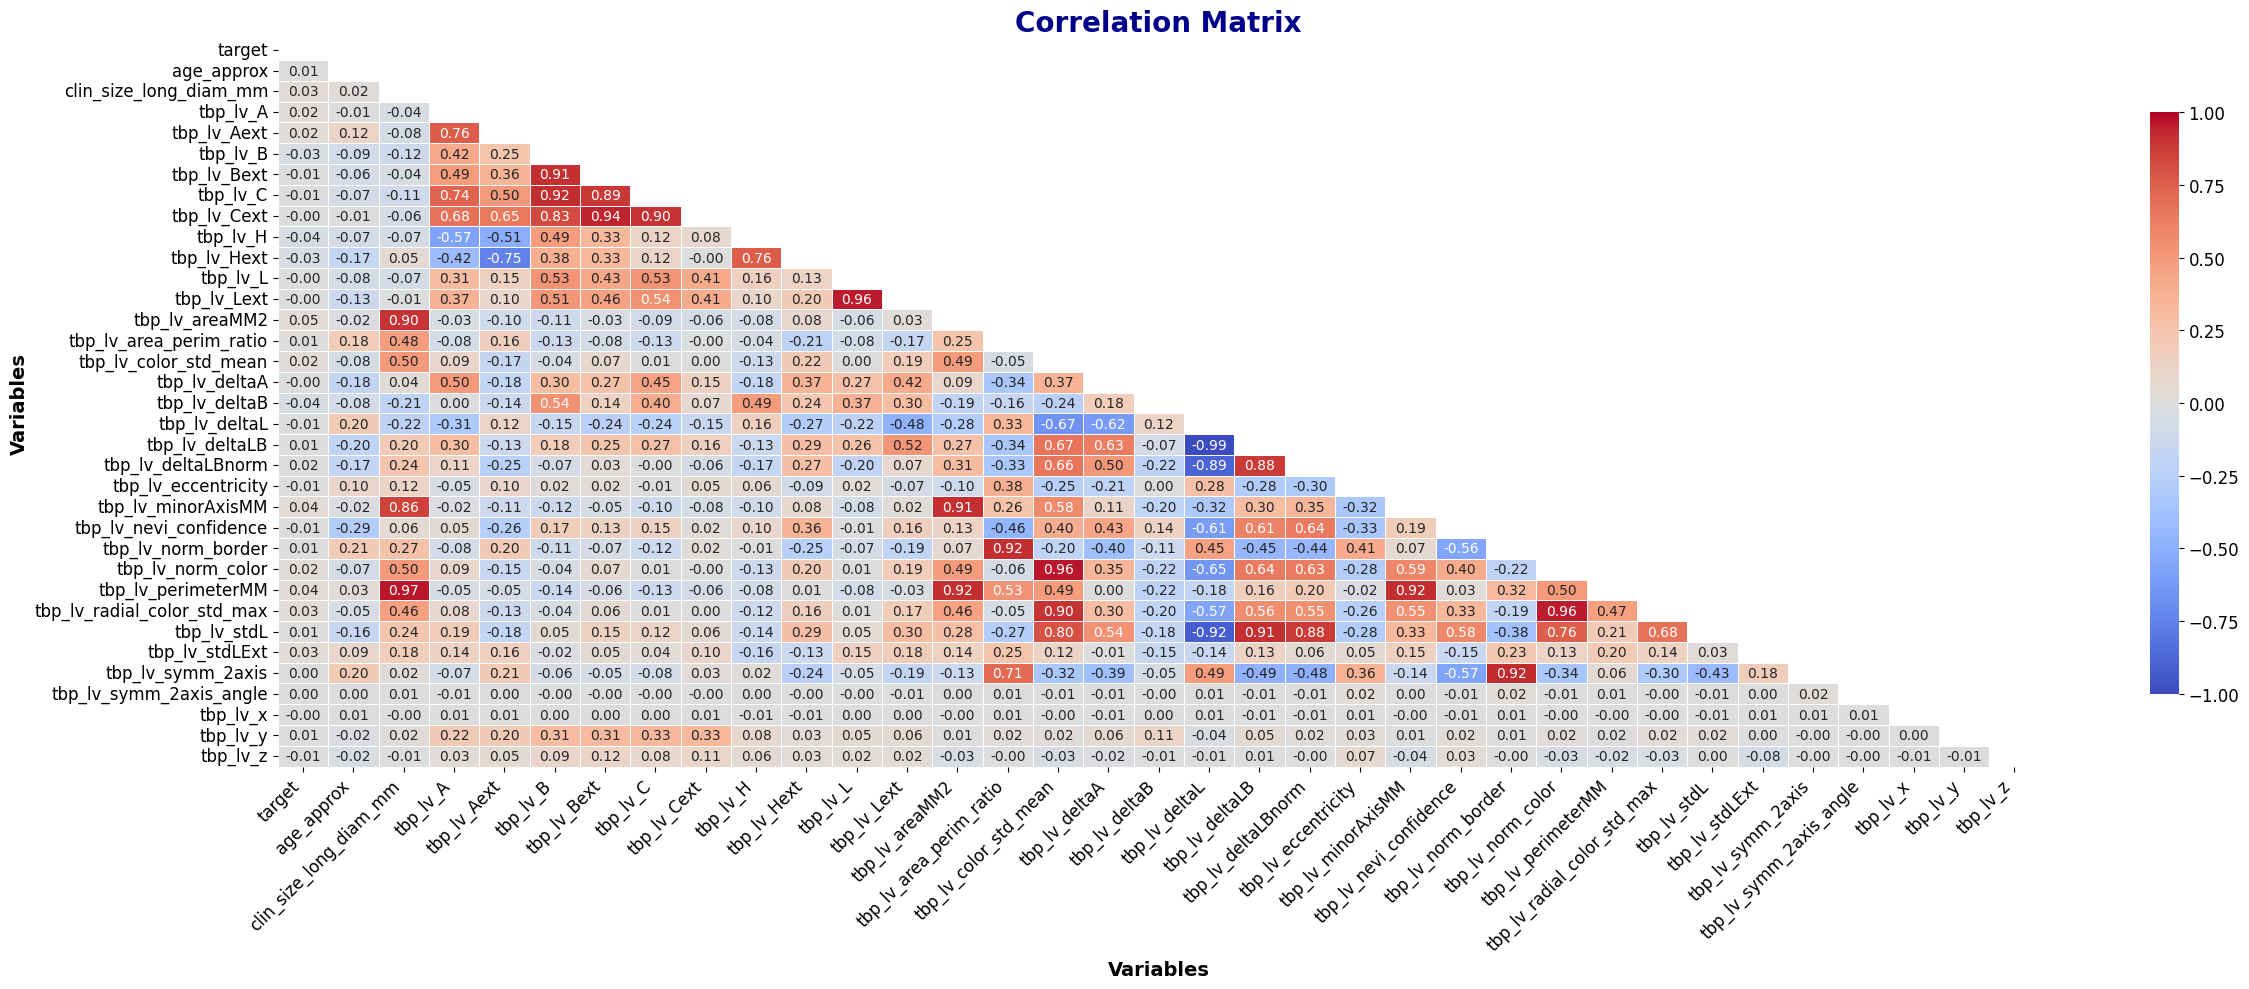

In [11]:
#############
## CORR MATRIX
#############

num_cols = train_metadata.select_dtypes(include=[np.number]).columns.tolist()
corr = train_metadata[num_cols].corr()
plt.figure(figsize=(25, 10))

mask = np.triu(np.ones_like(corr, dtype=bool))

ax = sns.heatmap(corr, mask=mask, annot=True, fmt=".2f", linewidths=0.5,
                 cmap='coolwarm', vmin=-1, vmax=1, cbar_kws={"shrink": .8},
                 xticklabels=corr.columns, yticklabels=corr.columns)

plt.title('Correlation Matrix', fontsize=20, fontweight='bold', color='darkblue')
plt.xticks(fontsize=12, rotation=45, ha='right')
plt.yticks(fontsize=12, rotation=0)
plt.xlabel('Variables', fontsize=14, fontweight='bold', color='black')
plt.ylabel('Variables', fontsize=14, fontweight='bold', color='black')

cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=12)

plt.tight_layout()
plt.show();

In [12]:
# High Correlations

threshold = 0.9

for i in range(len(corr.columns)):
    for j in range(i):
        if abs(corr.iloc[i, j]) > threshold:
            correlation_value = corr.iloc[i, j]
            var1 = corr.columns[i]
            var2 = corr.columns[j]
            color = "\033[93m"
            reset_color = "\033[0m"
            print(f"{color}{var1} ve {var2}: {correlation_value:.2f}{reset_color}")

tbp_lv_Bext ve tbp_lv_B: 0.91
tbp_lv_C ve tbp_lv_B: 0.92
tbp_lv_Cext ve tbp_lv_Bext: 0.94
tbp_lv_Cext ve tbp_lv_C: 0.90
tbp_lv_Lext ve tbp_lv_L: 0.96
tbp_lv_areaMM2 ve clin_size_long_diam_mm: 0.90
tbp_lv_deltaLB ve tbp_lv_deltaL: -0.99
tbp_lv_minorAxisMM ve tbp_lv_areaMM2: 0.91
tbp_lv_norm_border ve tbp_lv_area_perim_ratio: 0.92
tbp_lv_norm_color ve tbp_lv_color_std_mean: 0.96
tbp_lv_perimeterMM ve clin_size_long_diam_mm: 0.97
tbp_lv_perimeterMM ve tbp_lv_areaMM2: 0.92
tbp_lv_perimeterMM ve tbp_lv_minorAxisMM: 0.92
tbp_lv_radial_color_std_max ve tbp_lv_color_std_mean: 0.90
tbp_lv_radial_color_std_max ve tbp_lv_norm_color: 0.96
tbp_lv_stdL ve tbp_lv_deltaL: -0.92
tbp_lv_stdL ve tbp_lv_deltaLB: 0.91
tbp_lv_symm_2axis ve tbp_lv_norm_border: 0.92


In [13]:
#######
# DROP
#######

# Variables with high correlation or those that are derived from each other have been dropped.

unnec_list = [
    'tbp_lv_Bext',
    'tbp_lv_Cext',
    'tbp_lv_Lext',
    'tbp_lv_deltaLB',
    'tbp_lv_deltaLBnorm',
    'tbp_lv_stdL',
    'tbp_lv_norm_color',
    'tbp_lv_location'
]

train_metadata.drop(unnec_list, axis=1, inplace=True)

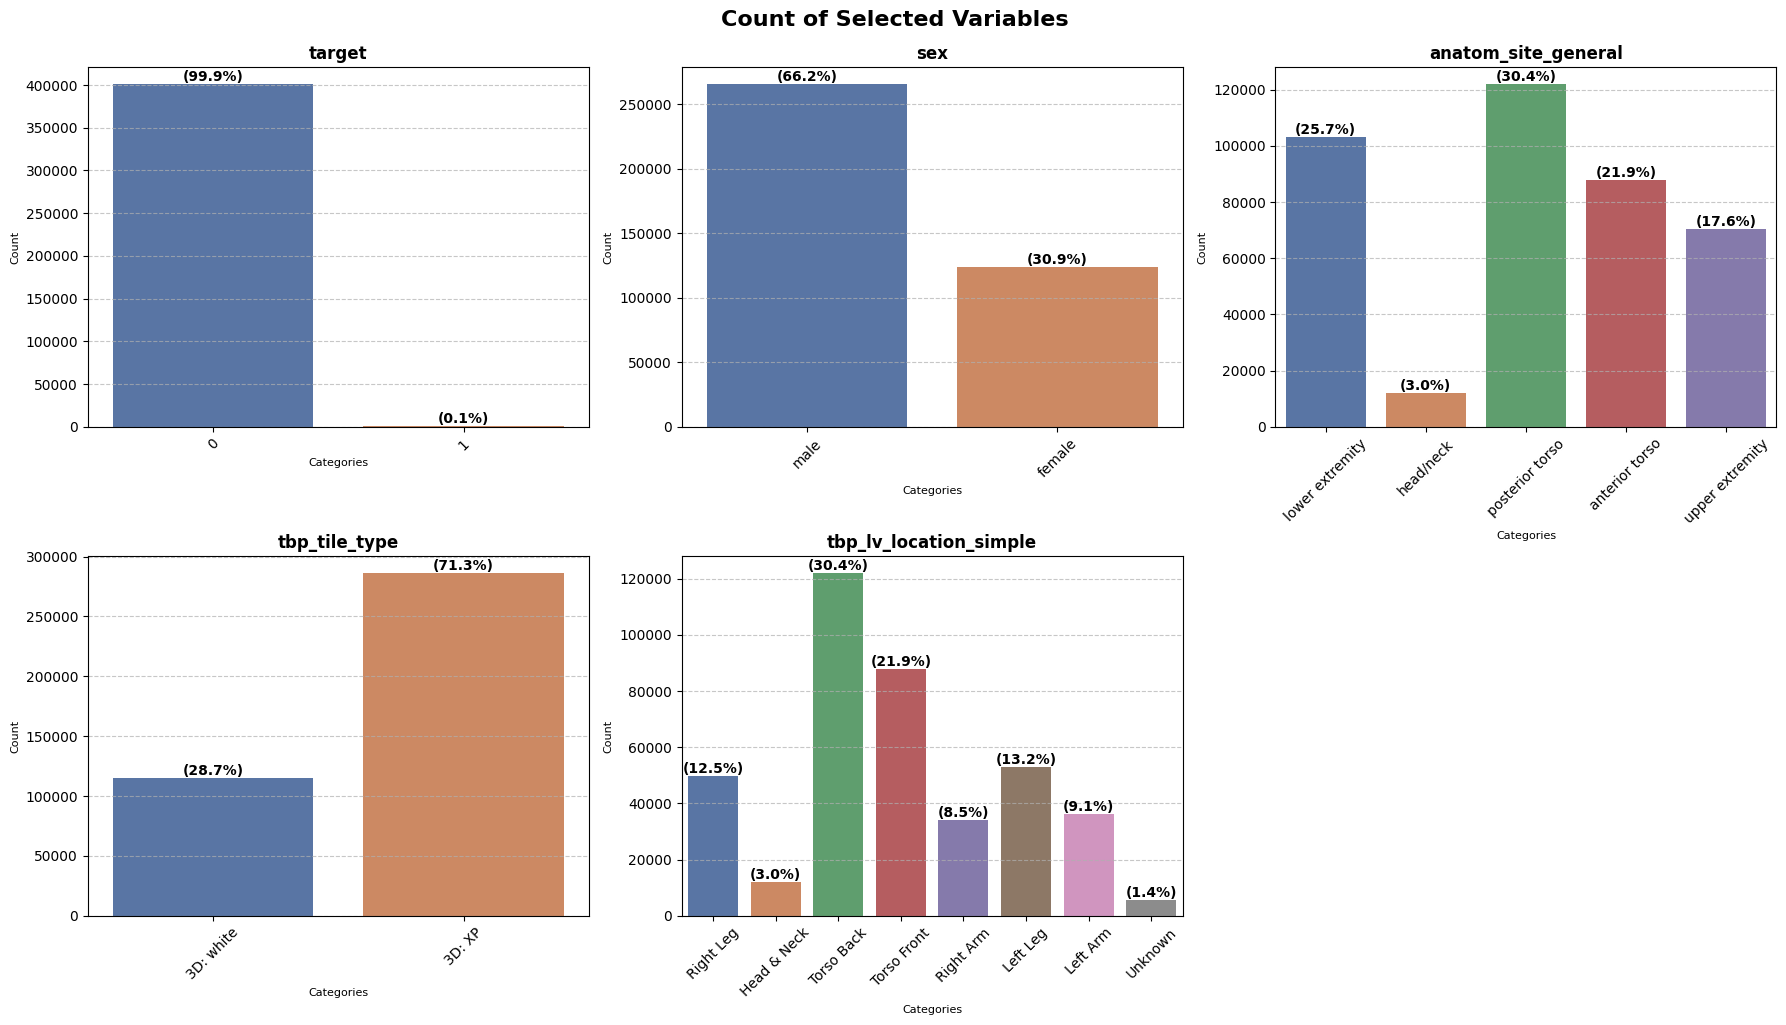

In [16]:
#############
# COUNTPLOT
#############

variables_to_plot = ['target', 'sex', 'anatom_site_general', 'tbp_tile_type', 'tbp_lv_location_simple']

num_columns = 3
num_rows = (len(variables_to_plot) + num_columns - 1) // num_columns

fig, axes = plt.subplots(num_rows, num_columns, figsize=(18, 5 * num_rows))
palette = sns.color_palette("deep")

for i, column in enumerate(variables_to_plot):
    ax = axes[i // num_columns, i % num_columns]
    sns.countplot(data=train_metadata, x=column, ax=ax, palette=palette)

    ax.set_title(column, fontsize=12, fontweight='bold')
    ax.set_ylabel('Count', fontsize=8)
    ax.set_xlabel('Categories', fontsize=8)

    ax.tick_params(axis='x', rotation=45)

    total = len(train_metadata)
    for p in ax.patches:
        count = p.get_height()
        percentage = count / total * 100
        ax.annotate(f'({percentage:.1f}%)',
                    (p.get_x() + p.get_width() / 2., count),
                    ha='center', va='bottom', fontsize=10, fontweight='bold')

    ax.grid(axis='y', linestyle='--', alpha=0.7)

for j in range(i + 1, num_rows * num_columns):
    fig.delaxes(axes.flatten()[j])

plt.tight_layout()
plt.suptitle('Count of Selected Variables', fontsize=16, fontweight='bold', y=1.02)
plt.show();

## Visualization

In [19]:
##################
# TRAIN IMG PATHS
##################

def get_images_path(image_dir):
    images_path = {}
    for root, dirs, files in os.walk(image_dir):
        for file in files:
            if file.endswith('.jpg'):
                image_id = os.path.splitext(file)[0]
                image_path = os.path.join(root, file)
                images_path[image_id] = image_path
    return images_path

images_path = get_images_path(train_image_dir)
train_metadata['img_paths'] = train_metadata['isic_id'].map(images_path)

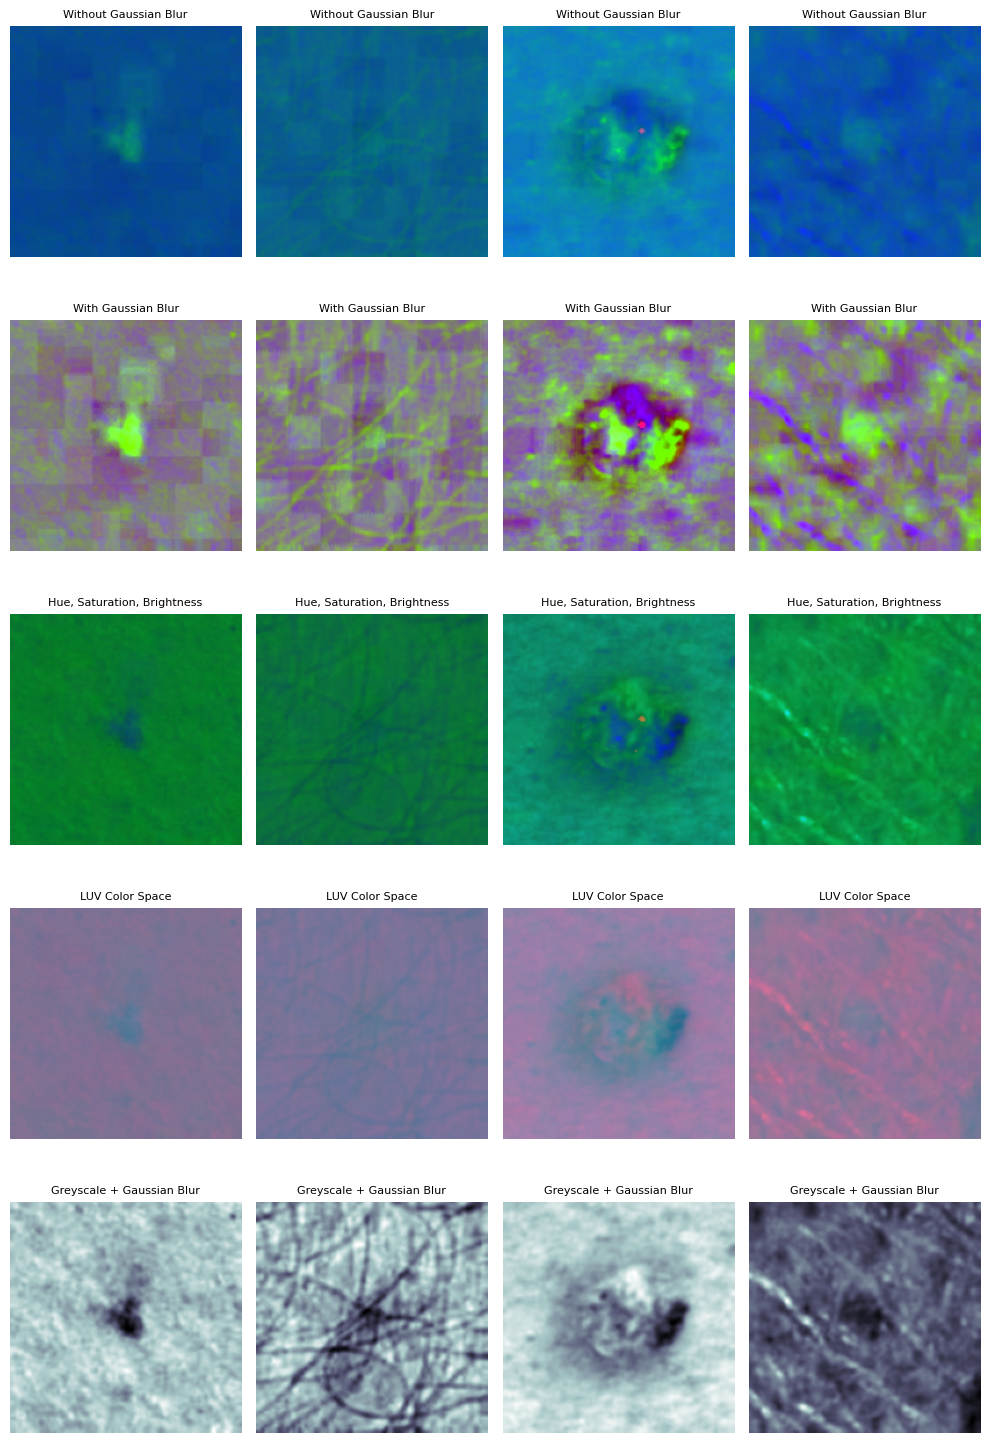

In [20]:
################################
# IMAGE TRANFORMATION TECHNIQUES
################################

#Aim to improve the robustness and performance of the model by providing varied representations of the input images

selected_ids = ['ISIC_4851249', 'ISIC_3646371', 'ISIC_3149970', 'ISIC_6286734']
selected_img_path = train_metadata.loc[train_metadata['isic_id'].isin(selected_ids), 'img_paths']


def apply_transformations(image_paths):
    fig, axes = plt.subplots(nrows=5, ncols=4, figsize=(10, 15))
    methods = ["Without Gaussian Blur", "With Gaussian Blur", "Hue, Saturation, Brightness", "LUV Color Space", "Greyscale + Gaussian Blur"]

    for index, method in enumerate(methods):
        for i, path in enumerate(image_paths):
            image = cv2.imread(path)

            if image is None:
                print(f"Image at {path} could not be loaded.")
                continue

            if method == "Without Gaussian Blur":
                transformed_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
                transformed_image = cv2.resize(transformed_image, (200, 200))

            elif method == "With Gaussian Blur":
                transformed_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
                transformed_image = cv2.resize(transformed_image, (200, 200))
                transformed_image = cv2.addWeighted(transformed_image, 4, cv2.GaussianBlur(transformed_image, (0, 0), 256/10), -4, 128)

            elif method == "Hue, Saturation, Brightness":
                transformed_image = cv2.cvtColor(image, cv2.COLOR_BGR2HLS)
                transformed_image = cv2.resize(transformed_image, (200, 200))

            elif method == "LUV Color Space":
                transformed_image = cv2.cvtColor(image, cv2.COLOR_BGR2LUV)
                transformed_image = cv2.resize(transformed_image, (200, 200))

            elif method == "Greyscale + Gaussian Blur":
                transformed_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
                transformed_image = cv2.resize(transformed_image, (200, 200))
                transformed_image = cv2.GaussianBlur(transformed_image, (5, 5), 0)

            axes[index, i].imshow(transformed_image, cmap=plt.cm.bone if len(transformed_image.shape) == 2 else None)
            axes[index, i].axis('off')
            axes[index, i].set_title(method, fontsize=8)

    plt.tight_layout()
    plt.show()


apply_transformations(selected_img_path)

<Figure size 1600x300 with 0 Axes>

Text(0.5, 0.98, 'Original Images')

<Axes: >

(-0.5, 299.5, 299.5, -0.5)

<Axes: >

(-0.5, 299.5, 299.5, -0.5)

<Axes: >

(-0.5, 299.5, 299.5, -0.5)

<Axes: >

(-0.5, 299.5, 299.5, -0.5)

<Axes: >

(-0.5, 299.5, 299.5, -0.5)

<Axes: >

(-0.5, 299.5, 299.5, -0.5)

<Figure size 1600x300 with 0 Axes>

Text(0.5, 0.98, 'Non Hairy Images')

<Axes: >

(-0.5, 299.5, 299.5, -0.5)

<Axes: >

(-0.5, 299.5, 299.5, -0.5)

<Axes: >

(-0.5, 299.5, 299.5, -0.5)

<Axes: >

(-0.5, 299.5, 299.5, -0.5)

<Axes: >

(-0.5, 299.5, 299.5, -0.5)

<Axes: >

(-0.5, 299.5, 299.5, -0.5)

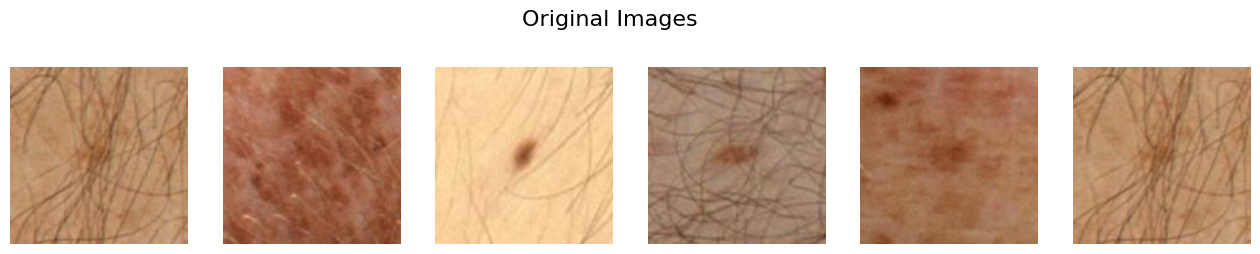

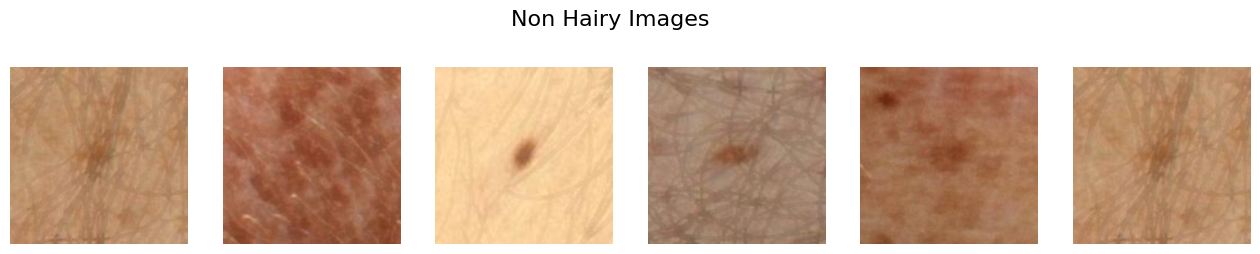

In [21]:
#############
# HAIR REMOVE
#############

all_image_paths = train_metadata['img_paths'].tolist()
image_hair = np.array(all_image_paths)[[13, 9473, 267, 167, 87, 13]]


plt.figure(figsize=(16,3))
plt.suptitle("Original Images", fontsize = 16)

for k, path in enumerate(image_hair[:6]):
    image = mpimg.imread(path)
    image = cv2.resize(image,(300, 300))

    plt.subplot(1, 6, k+1)
    plt.imshow(image)
    plt.axis('off')


#####################################


def hair_remove(image):
    grayScale = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    kernel = cv2.getStructuringElement(1,(17,17))
    blackhat = cv2.morphologyEx(grayScale, cv2.MORPH_BLACKHAT, kernel)
    _, threshold = cv2.threshold(blackhat, 10, 255, cv2.THRESH_BINARY)
    final_image = cv2.inpaint(image, threshold, 1, cv2.INPAINT_TELEA)

    return final_image


plt.figure(figsize=(16,3))
plt.suptitle("Non Hairy Images", fontsize = 16)

for k, path in enumerate(image_hair):
    image = mpimg.imread(path)
    image = cv2.resize(image,(300, 300))
    image = hair_remove(image)

    plt.subplot(1, 6, k+1)
    plt.imshow(image)
    plt.axis('off')

In [22]:
########
# DROP
########

final_drop = ["isic_id", "tbp_lv_location_simple"]
train_metadata.drop(final_drop, axis=1, inplace=True)

In [25]:
##############
# EXPORT DATA
##############

file_path = '/content/drive/MyDrive/Skin Cancer Detection/exploratory_data_analysis.csv'
train_metadata.to_csv(file_path, index=False)